Offline validation $R^2$ profiles

In [9]:
import os
import xarray as xr
import numpy as np
import fsspec
from matplotlib import pyplot as plt
import matplotlib as mpl
import string
from cycler import cycler


In [10]:
mpl.rcParams.update({'font.size': 8})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [colors[ind] for ind in [0, 8, 6]]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

In [11]:
CASES = {
    '$TqR$-RF': ['gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/offline_diags/postphysics_ML_tendencies/offline_diagnostics.nc'],
    '$TquvR$-NN': [
        'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dq1-dq2/offline_diagnostics.nc',
        'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dqu-dqv/offline_diagnostics.nc'
    ],
    '$TquvR$-NN \n non-reg' : [
        'gs://vcm-ml-experiments/2021-12-02-nudge-to-c3072-regularization-sensitivitity/non-reg/ensemble/offline_diags/dQ1-dQ2-non-reg/offline_diagnostics.nc',
        'gs://vcm-ml-experiments/2021-12-02-nudge-to-c3072-regularization-sensitivitity/non-reg/ensemble/offline_diags/dQu-dQv-non-reg/offline_diagnostics.nc'
    ],
    '$TquvR$-RF': ['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/offline_diags/postphysics_ML_tendencies/offline_diagnostics.nc'],

}

OUTPUTDIR = 'figures'

In [12]:
KEEP_VARS = [
    'pressure_level-mse-dQ1-predict_vs_target',
    'pressure_level-mse-dQ2-predict_vs_target',
    'pressure_level-mse-dQu-predict_vs_target',
    'pressure_level-mse-dQv-predict_vs_target',
    'pressure_level-mse-dQ1-mean_vs_target',
    'pressure_level-mse-dQ2-mean_vs_target',
    'pressure_level-mse-dQu-mean_vs_target',
    'pressure_level-mse-dQv-mean_vs_target'
]


def open_diags(path):
    with fsspec.open(path, 'rb') as f:
        ds = xr.open_dataset(f).load()
    return ds

datasets = []
for case, paths in CASES.items():
    print(case)
    if len(paths) == 1:
        ds = open_diags(paths[0]).assign_coords({'cases': case})
    else:
        case_datasets = []
        for path in paths:
            case_datasets.append(open_diags(path))
        ds = xr.merge(case_datasets, compat='override')
    for variable in ['dQu', 'dQv']:
        if variable not in ds:
            ds[variable] = xr.full_like(ds['dQ1'], np.nan)
    for variable in [
        'pressure_level-mse-dQu-predict_vs_target',
        'pressure_level-mse-dQv-predict_vs_target',
        'pressure_level-mse-dQu-mean_vs_target',
        'pressure_level-mse-dQv-mean_vs_target'
    ]:
        if variable not in ds:
            ds[variable] = xr.full_like(ds['pressure_level-mse-dQ1-predict_vs_target'], np.nan)
    datasets.append(ds[KEEP_VARS].assign_coords({'cases': case}))
diags = xr.concat(datasets, dim="cases")
diags = diags.assign_coords(pressure=(diags.pressure/100).assign_attrs({'units': 'hPa'}))

$TqR$-RF
$TquvR$-NN
$TquvR$-NN 
 non-reg
$TquvR$-RF


In [13]:
R2_VARS = {
    'dQ1': 'K/s',
    'dQ2': 'kg/kg/s',
    'dQu': 'm/s^2',
    'dQv': 'm/s^2'
}

def add_R2(ds):
    for var in R2_VARS:
        ds[f"pressure_level-R2-{var}"] = 1.0 - ds[f'pressure_level-mse-{var}-predict_vs_target']/ds[f'pressure_level-mse-{var}-mean_vs_target']
    return ds

diags = add_R2(diags)

In [14]:
#color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c',]) 
color_cycler = cycler(color=['#006BA4', '#FFBC79', '#FFBC79', '#898989']
) 


linestyle_cycler = cycler(linestyle= ["-", "-", "--", "-"])
mpl.rcParams['axes.prop_cycle'] = linestyle_cycler + color_cycler


In [15]:
def plot_R2_cases(da):
    fg = da.plot(y='pressure', yincrease=False, hue='cases', col='variable', lw=2, add_legend=False)
    fg.set_ylabels('pressure [hPa]')
    fg.set_xlabels('$R^{2}$')
    for i, ax in enumerate(fg.axes.flatten()):

        if i == 3:
            ax.legend(labels=da.cases.values)
            
        ax.set_xlim([0, 0.45])
        ax.set_ylim([1.0e3, 0])
        ax.grid(axis='x')
        ax.set_title(f"{string.ascii_lowercase[i]}) {da.coords['variable'].values[i]}")
    fg.fig.set_size_inches([7.6, 3])
    fg.fig.savefig(os.path.join(OUTPUTDIR, f"Figure_5_offline_R2_profiles.eps"), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


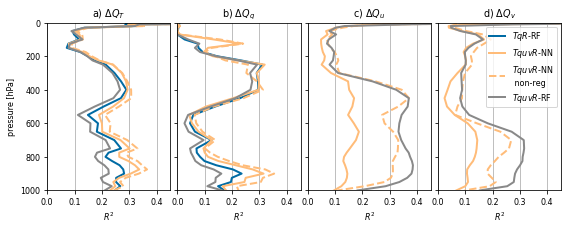

In [16]:
r2_da = diags[[f"pressure_level-R2-{var}" for var in R2_VARS.keys()]].to_array().assign_coords(
    variable=[
        '$\Delta Q_T$',
        '$\Delta Q_q$',
        '$\Delta Q_u$',
        '$\Delta Q_v$'
    ]
)
plot_R2_cases(r2_da)

In [ ]:
# # this converts matplotlib eps files to a more manageable size

!epstopdf figures/Figure_5_offline_R2_profiles.eps
!pdftops -eps figures/Figure_5_offline_R2_profiles.pdf
!rm figures/Figure_5_offline_R2_profiles.pdf